In [1]:

import numpy
import plotly
import numpy as np
import matplotlib.pyplot as plt
import kan
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.patches as mpatches
import networkx as nx
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import rcParams


from ipywidgets import interactive, FloatSlider
import ipywidgets as widgets
from matplotlib import cm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

fun = nn.ReLU()

def b1(x):
    return torch.sin(x)

def b2(x):
    return torch.cos(x)
    
def b3(x):
    return torch.sin(x)*torch.sin(x)

def b4(x):
    return torch.cos(x)*torch.cos(x)
    
def b5(x):
    return torch.cos(x)*torch.cos(x)*torch.cos(x)

def b6(x):
    return torch.sin(x)*torch.sin(x)*torch.sin(x)

def b7(x):
    return fun(x)



In [3]:
class KAN_layer(nn.Module):
    def __init__(self, n_in, n_out, masking_matrix):
        """
        n_in = number of input nodes
        n_out = number of output nodes
        masking_matrix = (n_out x n_in) matrix where entry q,p is 1 if
                         node q in the output layer is connected to node p in the input layer
        """
        super(KAN_layer, self).__init__()
        self.n_in = n_in
        self.n_out = n_out

        # Convert masking_matrix from list to torch.Tensor
        masking_tensor = torch.tensor(masking_matrix, dtype=torch.float32)
        
        # Register the tensor as a buffer
        self.register_buffer('masking_matrix', masking_tensor)

        # We need a weight for each (q, p) pair and each of the 10 basis functions
        # So weights shape will be: [n_out, n_in, 10]
        self.weights = nn.Parameter(torch.randn(n_out, n_in, 5))

    def forward(self, x):
        """
        x: input tensor of shape [batch_size, n_in]
        returns: output tensor of shape [batch_size, n_out]
        """
        # Compute the 5 basis functions for each input:
        # basis will have shape: [batch_size, n_in, 5]
        basis = torch.stack([b1(x), b2(x), b3(x), b4(x), b5(x)], dim=2)

        # Expand dimensions to align with weights:
        # basis: [batch_size, n_in, 10] -> [batch_size, 1, n_in, 10]
        basis_exp = basis.unsqueeze(1)  # Insert a dimension for output nodes

        # weights: [n_out, n_in, 10] -> [1, n_out, n_in, 10] for broadcasting
        weights_exp = self.weights.unsqueeze(0)

        # masking_matrix: [n_out, n_in] -> [1, n_out, n_in, 1]
        # to broadcast along batch and functions dimension
        mask_exp = self.masking_matrix.unsqueeze(0).unsqueeze(-1)

        # Apply the mask and sum:
        # (basis_exp * weights_exp * mask_exp) has shape [batch_size, n_out, n_in, 10]
        # Summing over n_in and 10:
        output = (basis_exp * weights_exp * mask_exp).sum(dim=(2,3))

        # Now output shape is [batch_size, n_out] as desired
        return output


In [4]:
class KAN_net(nn.Module):  # this is the custom class for the overall network
    def __init__(self, input_dim, hidden_vec, output_dim, masking_matrices):
        '''
        Args:
        - input_dim: int, dimension of the input layer
        - hidden_vec: list of int, corresponding to the width of each hidden layer
        - output_dim: int, dimension of the output layer
        - masking_matrices: list of length (len(hidden_vec)+1), each a masking matrix 
                            for the corresponding layer. The i-th matrix should have 
                            shape [hidden_vec[i], input_dim] if i==0 or 
                            [hidden_vec[i], hidden_vec[i-1]] for i > 0, and the last 
                            one should have shape [output_dim, hidden_vec[-1]].
        '''
        super(KAN_net, self).__init__()
        
        # We'll store the layers in a ModuleList
        self.layers = nn.ModuleList()

        # If we have hidden layers:
        if len(hidden_vec) > 0:
            # Input -> first hidden
            self.layers.append(KAN_layer(input_dim, hidden_vec[0], masking_matrices[0]))
            
            # Hidden -> hidden
            for i in range(len(hidden_vec)-1):
                self.layers.append(KAN_layer(hidden_vec[i], hidden_vec[i+1], masking_matrices[i+1]))
            
            # Last hidden -> output
            self.layers.append(KAN_layer(hidden_vec[-1], output_dim, masking_matrices[-1]))
        
        else:
            # No hidden layers, single KAN_layer from input to output
            self.layers.append(KAN_layer(input_dim, output_dim, masking_matrices[0]))

    def forward(self, x):
        # Pass input through all layers
        for i, layer in enumerate(self.layers):
            x = layer(x)
        out = x
        return out


In [5]:
#CREATE MASK

def ka_decomposition_masks(n: int, e: int, d: int = 1):
    """
    Generate masking matrices for a KA decomposition-based neural network structure.

    Parameters
    ----------
    n : int
        The dimension of the original input (f: R^n -> R).
    e : int
        The expansion factor for each φ_{q,p}, i.e., φ'_{q,p}(x_p, ..., x_p) is now from R^e -> R.
    d : int
        The depth of nested KA decompositions. Currently, this implementation assumes d=1.

    Returns
    -------
    masking_matrices : list of np.ndarray
        A list of binary masking matrices (0/1) for each layer.
        Each element is a mask of shape (layer_output_dim, layer_input_dim).
    """
    if d != 1:
        raise NotImplementedError("Only d=1 is implemented.")

    # Layer Dimensions
    dim_input = (2 * n + 1) * n * e
    dim_l1_out = (2 * n + 1) * n * (2 * e + 1)
    dim_l2_out = (2 * n + 1) * n
    dim_l3_out = (2 * n + 1)
    dim_l4_out = 1

    # Initialize Masks
    mask_l1 = np.zeros((dim_l1_out, dim_input), dtype=np.float32)
    mask_l2 = np.zeros((dim_l2_out, dim_l1_out), dtype=np.float32)
    mask_l3 = np.zeros((dim_l3_out, dim_l2_out), dtype=np.float32)
    mask_l4 = np.ones((dim_l4_out, dim_l3_out), dtype=np.float32)  # Fully connected

    # ------------- Layer 1 Mask -------------
    # Connect each (q, p) input block (size e) to (q, p) output block (size 2e+1)
    for q in range(2 * n + 1):
        for p in range(n):
            # Input indices for the (q, p) block
            in_start = (q * n + p) * e
            in_end = in_start + e

            # Output indices for the (q, p) block
            out_start = (q * n + p) * (2 * e + 1)
            out_end = out_start + (2 * e + 1)

            # Fully connect this (q, p) block
            mask_l1[out_start:out_end, in_start:in_end] = 1.0

    # ------------- Layer 2 Mask -------------
    # Each (q, p) output node in Layer 2 connects only to its corresponding (q, p) block in Layer 1
    for q in range(2 * n + 1):
        for p in range(n):
            # Layer 2 output index
            l2_out_idx = q * n + p

            # Corresponding Layer 1 input block indices
            l1_in_start = (q * n + p) * (2 * e + 1)
            l1_in_end = l1_in_start + (2 * e + 1)

            # Connect all (2e+1) units from Layer 1 to this Layer 2 unit
            mask_l2[l2_out_idx, l1_in_start:l1_in_end] = 1.0

    # ------------- Layer 3 Mask -------------
    # Each Layer 2 node (q, p) connects to its corresponding q node in Layer 3
    for q in range(2 * n + 1):
        for p in range(n):
            # Layer 3 output index
            l3_out_idx = q

            # Layer 2 input index
            l2_in_idx = q * n + p

            # Connect Layer 2 node to Layer 3 node
            mask_l3[l3_out_idx, l2_in_idx] = 1.0

    # ------------- Layer 4 Mask -------------
    # Already initialized as fully connected

    masking_matrices = [mask_l1, mask_l2, mask_l3, mask_l4]

    return masking_matrices, [dim_input, dim_l1_out, dim_l2_out, dim_l3_out, dim_l4_out]

In [6]:

f1 = lambda x: x[:,[0]]+torch.cos(x[:,[1]])
f2 = lambda x: torch.cos(torch.sin(x[:,[0]] + x[:,[1]]) + x[:,[0]] + x[:,[1]])
f3 = lambda x: torch.sqrt(torch.sin(x[:,[0]])+x[:,[1]])


target_function_list = [f1, f2, f3]

# Define additional masks (mask2 and mask3) as per your original code
mask2 = [
    [[1, 1],
     [1, 1],
     [1, 1],
     [1, 1],
     [1, 1]],
    
    [[1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1]],
     
    [[1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1]],
    
    [[1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1]],
    
    [[1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1]],
    
    [[1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1]],
    
    [[1, 1, 1, 1, 1]]
]

mask3 = [
    [[1, 1],
     [1, 1],
     [1, 1],
     [1, 1],
     [1, 1],
     [1, 1],
     [1, 1],
     [1, 1],
     [1, 1],
     [1, 1]],
    
    [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
    
    [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],

     [[1,1,1,1]]
]

# Define corresponding hidden layer sizes
hidden_list = [
    # For mask1
    ka_decomposition_masks(n=2, e=2, d=1)[1],
    
    # For mask2
    [2, 5, 5, 5, 5, 5, 5, 5, 1],
    
    # For mask3
    [2, 10, 10, 4, 1]
]

# List of masks
masks_list = [mask1 := ka_decomposition_masks(n=2, e=2, d=1)[0], mask2, mask3]


In [41]:
# Define named target functions
def function_1(x):
    return x[:, [0]] * x[:, [1]]

def function_2(x):
    return torch.cos(torch.sin(x[:, [0]] + x[:, [1]]) + x[:, [0]] + x[:, [1]])

def function_3(x):
    return torch.exp(torch.sin(x[:, [0]]) + x[:, [1]])

target_function_list = [function_1, function_2, function_3]

# ... [Your existing code for masks, hidden_list, masks_list, etc.] ...

# Initialize a results list to store all losses and predictions

num_epochs=50
batch_size = 25
train_num = 5000
test_num = 1000
learning_rate = 0.001
criterion = nn.MSELoss()

In [8]:
# MAIN TRAINING LOOP
results = []
# Loop over each target function
for idx_f, target_function in enumerate(target_function_list):
    print(f"Running for target function {idx_f+1}/{len(target_function_list)}: {target_function.__name__}")
    input_dim = 2
    output_dim = 1

    # Create the dataset for the current target function
    dataset_dict = kan.create_dataset(
        target_function, 
        n_var=input_dim, 
        device=device,
        ranges=[-1, 1], 
        train_num=train_num, 
        test_num=test_num
    )

    train_input = dataset_dict['train_input']  # shape: (train_num, input_dim)
    train_label = dataset_dict['train_label']  # shape: (train_num, output_dim)
    test_input = dataset_dict['test_input']    # shape: (test_num, input_dim)
    test_label = dataset_dict['test_label']    # shape: (test_num, output_dim)

    # Loop over each architecture
    for idx_arch, (hidden_vec, masking_matrices) in enumerate(zip(hidden_list, masks_list)):
        print(f"  Architecture {idx_arch+1}/{len(hidden_list)}")
        current_input_dim = 2  # Use a different variable to avoid confusion
        current_train_input = train_input[:, :2]

        if idx_arch == 0:
            current_input_dim = 20
            current_train_input = current_train_input.repeat(1, 10)

        train_dataset = TensorDataset(current_train_input, train_label)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Create the model
        model = KAN_net(current_input_dim, hidden_vec[1:-1], output_dim, masking_matrices).to(device)
        # Create an optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Initialize a list to store training losses for this run
        training_losses = []

        # (Optional) Train the model
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch_x, batch_y in train_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                optimizer.zero_grad()
                # Forward pass
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * batch_x.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            training_losses.append(epoch_loss)  # Collect training loss
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f"    Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # After training, evaluate on the test set
        model.eval()
        with torch.no_grad():
            current_test_input = test_input[:, :2]
            if idx_arch == 0:
                current_test_input = current_test_input.repeat(1, 10)

            test_output = model(current_test_input)
            # Compute test loss
            test_loss = criterion(test_output, test_label).item()
            print(f"    Test Loss: {test_loss:.4f}")

        # Store the results for this run, including predictions
        run_result = {
            'target_function_index': idx_f,
            'target_function': target_function.__name__,
            'architecture_index': idx_arch,
            'hidden_layers': hidden_vec,
            'masking_matrices': masking_matrices,
            'training_losses': training_losses,
            'test_loss': test_loss,
            'test_predicted': test_output.cpu(),  
            'test_actual': test_label.cpu()
        }
        results.append(run_result)

        del model
        torch.cuda.empty_cache()




Running for target function 1/3: f1
  Architecture 1/3
    Epoch [1/50], Loss: 2.5742
    Epoch [5/50], Loss: 0.4956
    Epoch [10/50], Loss: 0.2004
    Epoch [15/50], Loss: 0.0996
    Epoch [20/50], Loss: 0.0632
    Epoch [25/50], Loss: 0.0461
    Epoch [30/50], Loss: 0.0343
    Epoch [35/50], Loss: 0.0218
    Epoch [40/50], Loss: 0.0126
    Epoch [45/50], Loss: 0.0092
    Epoch [50/50], Loss: 0.0077
    Test Loss: 0.0077
  Architecture 2/3
    Epoch [1/50], Loss: 6.8858
    Epoch [5/50], Loss: 2.4037
    Epoch [10/50], Loss: 0.7585
    Epoch [15/50], Loss: 0.2833
    Epoch [20/50], Loss: 0.1576
    Epoch [25/50], Loss: 0.1345
    Epoch [30/50], Loss: 0.1253
    Epoch [35/50], Loss: 0.1185
    Epoch [40/50], Loss: 0.1151
    Epoch [45/50], Loss: 0.1148
    Epoch [50/50], Loss: 0.1143
    Test Loss: 0.1071
  Architecture 3/3
    Epoch [1/50], Loss: 3.5491
    Epoch [5/50], Loss: 0.8901
    Epoch [10/50], Loss: 0.2475
    Epoch [15/50], Loss: 0.1341
    Epoch [20/50], Loss: 0.1151
    E

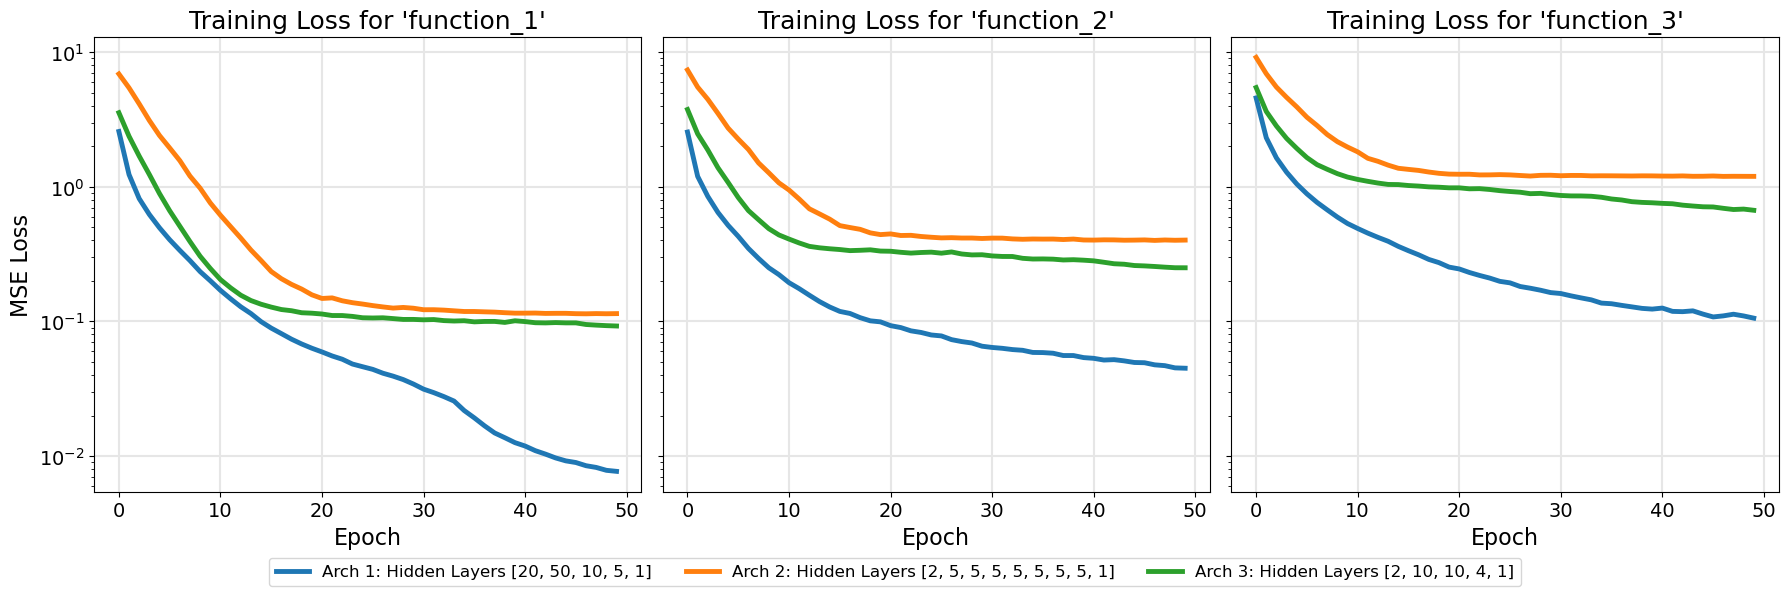

In [39]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Organize results by target function
results_by_target = defaultdict(list)
for run in results:
    results_by_target[run['target_function_index']].append(run)

# Determine the number of target functions
num_targets = len(target_function_list)

# Set up the subplots: 1 row and 'num_targets' columns
fig, axes = plt.subplots(
    1, 
    num_targets, 
    figsize=(6 * num_targets, 6), 
    sharey=True
)

# If there's only one target function, axes might not be a list, so make it iterable
if num_targets == 1:
    axes = [axes]

# Define styles for better readability
plot_linewidth = 3.5       # Thickness of the training loss lines
grid_linewidth = 1.5       # Thickness of the grid lines
legend_fontsize = 12       # Font size of the legend text
legend_linewidth = 2.5     # Thickness of the lines in the legend

# Define larger font sizes for axis labels and titles
xlabel_fontsize = 16
ylabel_fontsize = 16
title_fontsize = 18
tick_label_fontsize = 14

# To collect handles and labels for the centralized legend
handles = []
labels = []

# Plotting Training Losses for each target function
for idx_f, (target_function, ax) in enumerate(zip(target_function_list, axes)):
    runs = results_by_target[idx_f]
    for run in runs:
        arch_idx = run['architecture_index']
        hidden_layers = run['hidden_layers']
        label = f"Arch {arch_idx + 1}: Hidden Layers {hidden_layers}"
        
        # Plot with increased linewidth
        line, = ax.plot(
            run['training_losses'], 
            label=label, 
            linewidth=plot_linewidth
        )
        
        # Collect handles and labels only once
        if idx_f == 0:
            handles.append(line)
            labels.append(label)
    
    # Set titles and labels with increased font sizes
    ax.set_title(
        f"Training Loss for '{target_function.__name__}'", 
        fontsize=title_fontsize
    )
    ax.set_xlabel("Epoch", fontsize=xlabel_fontsize)
    
    # Only set the y-label for the first subplot to avoid redundancy
    if idx_f == 0:
        ax.set_ylabel("MSE Loss", fontsize=ylabel_fontsize)
    
    # Set y-axis to logarithmic scale for better visualization of loss decreases
    ax.set_yscale('log')
    
    # Enable grid with increased linewidth and a light gray color for subtlety
    ax.grid(True, linewidth=grid_linewidth, color='0.9')
    
    # Increase tick label font sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=tick_label_fontsize)

# Create a centralized legend below all subplots
fig.legend(
    handles, 
    labels, 
    fontsize=legend_fontsize, 
    frameon=True, 
    loc='lower center', 
    ncol=len(labels),  # Arrange legend items in a single row
    bbox_to_anchor=(0.5, 0.0)  # Position legend at the bottom center
)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust the bottom margin to accommodate the legend

plt.show()

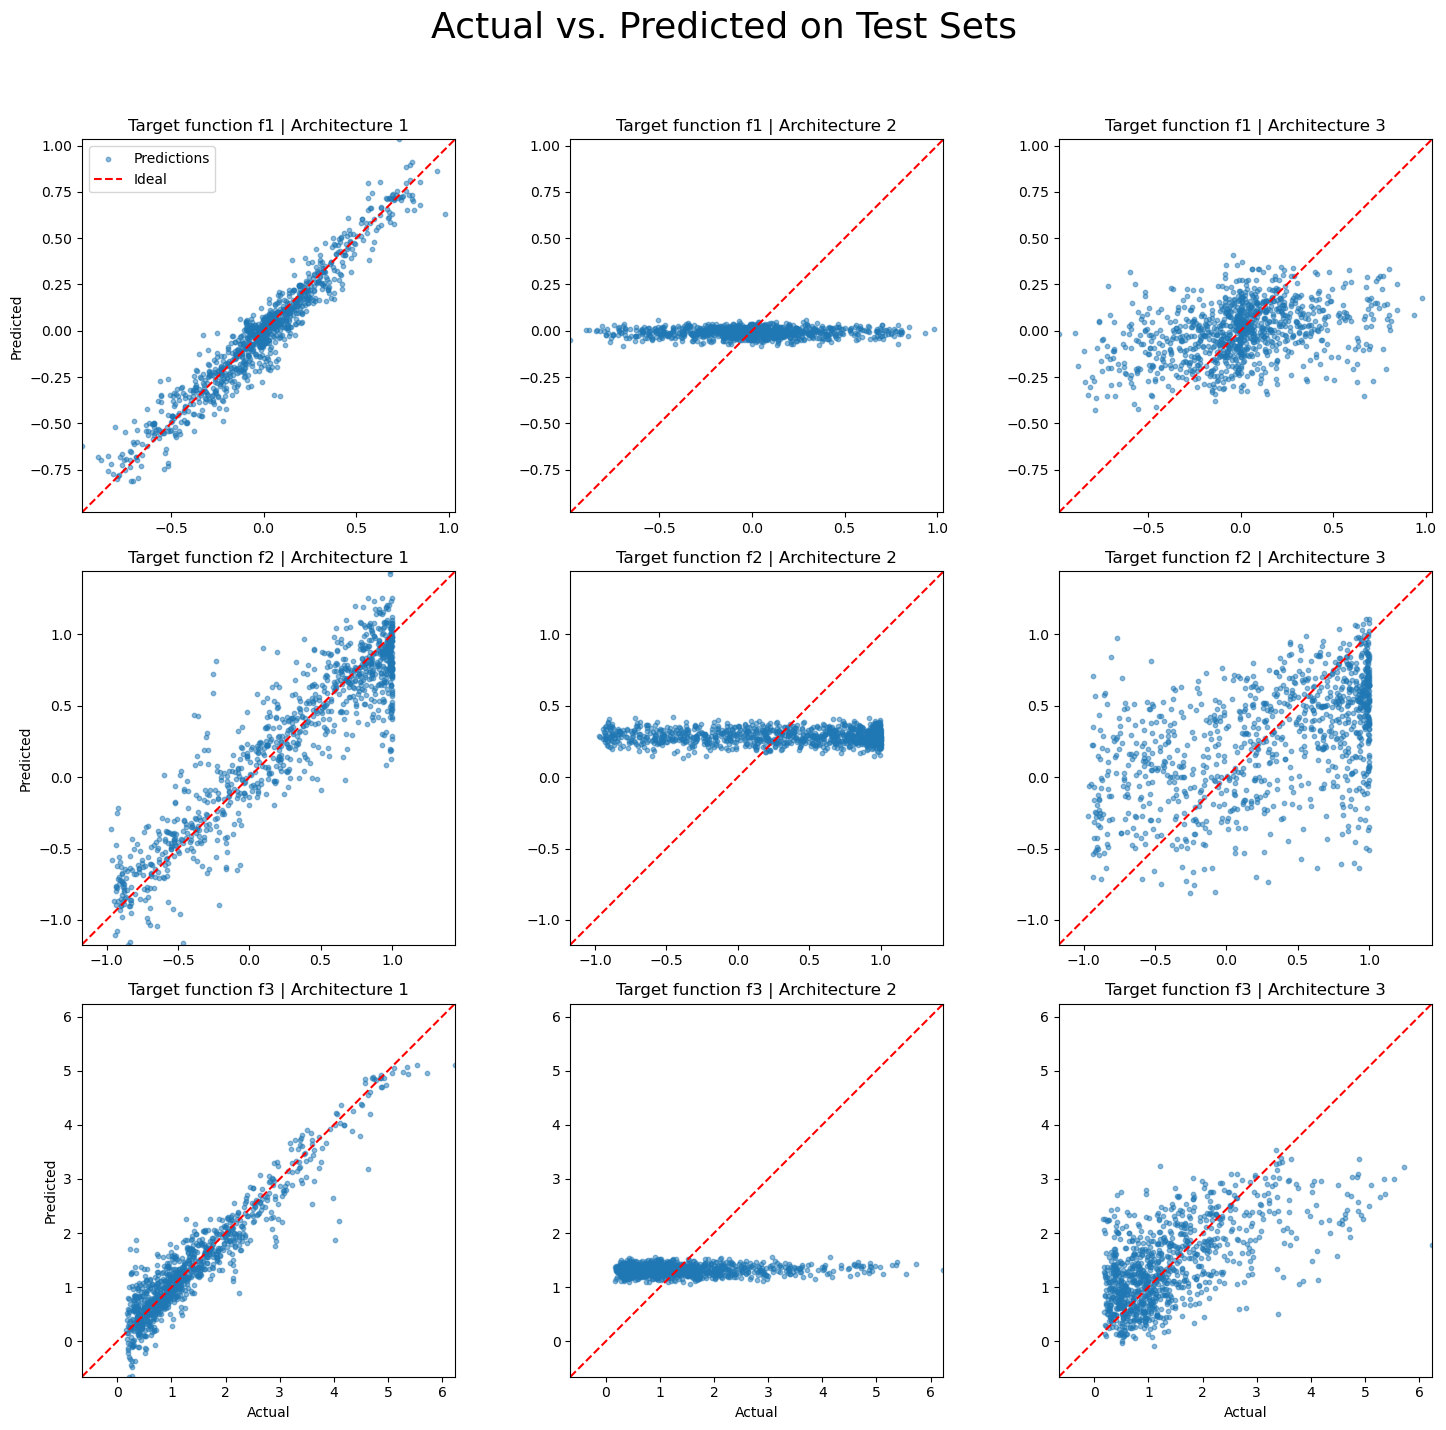

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of target functions and architectures
num_targets = len(target_function_list)
num_archs = len(hidden_list)

# Create a grid of subplots without sharing axes
fig, axes = plt.subplots(num_targets, num_archs, figsize=(5 * num_archs, 5 * num_targets))

# Ensure axes is a 2D array for consistent indexing
if num_targets == 1 and num_archs == 1:
    axes = np.array([[axes]])
elif num_targets == 1:
    axes = np.expand_dims(axes, axis=0)
elif num_archs == 1:
    axes = np.expand_dims(axes, axis=1)

# Organize results by target function and architecture
results_matrix = [[None for _ in range(num_archs)] for _ in range(num_targets)]
for run in results:
    tf_idx = run['target_function_index']
    arch_idx = run['architecture_index']
    results_matrix[tf_idx][arch_idx] = run

# Precompute axis ranges per row (target function)
axis_ranges = []
for tf_idx in range(num_targets):
    min_val = np.inf
    max_val = -np.inf
    for arch_idx in range(num_archs):
        run = results_matrix[tf_idx][arch_idx]
        if run is not None:
            actual = run['test_actual'].numpy().flatten()
            predicted = run['test_predicted'].numpy().flatten()
            min_val = min(min_val, actual.min(), predicted.min())
            max_val = max(max_val, actual.max(), predicted.max())
    if min_val == np.inf or max_val == -np.inf:
        # No runs in this row; set default limits
        min_val, max_val = 0, 1
    axis_ranges.append((min_val, max_val))

# Iterate through each target function and architecture to plot
for tf_idx, target_function in enumerate(target_function_list):
    min_val, max_val = axis_ranges[tf_idx]
    for arch_idx, arch_hidden in enumerate(hidden_list):
        run = results_matrix[tf_idx][arch_idx]
        ax = axes[tf_idx][arch_idx]
        
        if run is None:
            ax.set_visible(False)
            continue
        
        actual = run['test_actual'].numpy().flatten()
        predicted = run['test_predicted'].numpy().flatten()
        
        # Scatter Plot
        ax.scatter(actual, predicted, alpha=0.5, s=10, label='Predictions')
        
        # Diagonal Reference Line
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
        
        # Set 1:1 Aspect Ratio
        ax.set_aspect('equal', adjustable='box')
        
        # Set axis limits to the same range for both axes
        ax.set_xlim([min_val, max_val])
        ax.set_ylim([min_val, max_val])
        
        # Labels and Titles
        if tf_idx == num_targets - 1:
            ax.set_xlabel('Actual')
        if arch_idx == 0:
            ax.set_ylabel('Predicted')
        
        ax.set_title(f"Target function {run['target_function']} | Architecture {arch_idx + 1}")
        
        if tf_idx == 0 and arch_idx == 0:
            ax.legend(loc='upper left')

# Adjust layout and add a super title
plt.suptitle('Actual vs. Predicted on Test Sets', fontsize=26)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [100]:
import numpy as np
import matplotlib.pyplot as plt

def plot_network(masking_matrices, figsize=(15, 10), title="Network Visualization", ax=None):
    """
    Plot a KA decomposition-based neural network defined by the given masking matrices.

    Parameters
    ----------
    masking_matrices : list of np.ndarray
        The list of masking matrices defining connectivity between layers.
        Each element corresponds to one layer of weights and has shape (out_dim, in_dim).
    figsize : tuple of (width, height)
        Figure size for the plot. Ignored if ax is provided.
    title : str
        Title of the plot.
    ax : matplotlib.axes.Axes, optional
        The axes on which to plot the network. If None, a new figure and axes are created.
    """
    # If ax is not provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Ensure all masking matrices are NumPy arrays and 2D
    masking_matrices = [
        np.array(M) if not isinstance(M, np.ndarray) else M for M in masking_matrices
    ]
    masking_matrices = [
        M.reshape((1, -1)) if M.ndim == 1 else M for M in masking_matrices
    ]

    # Determine the dimensions of each layer of nodes
    layer_dims = []
    layer_dims.append(masking_matrices[0].shape[1])  # input dimension
    for M in masking_matrices:
        layer_dims.append(M.shape[0])

    n_layers = len(layer_dims)

    # Colors for each layer:
    colors = ['blue', 'green', 'red', 'purple', 'black']

    # Define vertical top and bottom boundaries for the nodes
    top = 0.9
    bottom = 0.1

    # Horizontal positioning of layers
    x_margin = 0.1
    x_positions = np.linspace(x_margin, 1 - x_margin, n_layers)

    # Compute node positions
    node_positions = []  # list of arrays, each array has shape (L, 2) for (x,y)
    for i, dim in enumerate(layer_dims):
        if dim == 1:
            # Center the single node vertically
            y_positions = np.array([(top + bottom) / 2.0])
        else:
            y_positions = np.linspace(top, bottom, dim)

        x = x_positions[i]
        coords = np.stack([np.full(dim, x), y_positions], axis=1)
        node_positions.append(coords)

    # Draw edges based on masking_matrices
    for i, M in enumerate(masking_matrices):
        in_coords = node_positions[i]
        out_coords = node_positions[i + 1]

        # Check if M is 2D
        if M.ndim != 2:
            raise ValueError(f"Masking matrix at index {i} is not 2-dimensional.")

        q_indices, p_indices = np.where(M == 1)
        for q, p in zip(q_indices, p_indices):
            x1, y1 = in_coords[p]
            x2, y2 = out_coords[q]
            ax.plot([x1, x2], [y1, y2], color='black', linewidth=1.5, alpha=0.7, zorder=1)

    # Draw nodes
    for i, coords in enumerate(node_positions):
        c = colors[i % len(colors)]
        x_vals = coords[:, 0]
        y_vals = coords[:, 1]
        ax.scatter(x_vals, y_vals, color=c, s=600, zorder=3, edgecolors='white', linewidth=1)

    # Label layers with their width and layer number at the bottom
    label_y = bottom - 0.1
    for i, dim in enumerate(layer_dims):
        ax.text(x_positions[i], label_y, f"Layer {i + 1}\nDim={dim}",
                ha='center', va='center', fontsize=25)

    # Add a title (only for the first subplot to avoid repetition)
    if ax is not None:
        # To handle multiple subplots, set the title outside the loop
        pass
    else:
        plt.title(title, fontsize=25, pad=20)

    # Remove axes and set limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    # If ax is None, show the plot
    if ax is None:
        plt.tight_layout()
        plt.show()


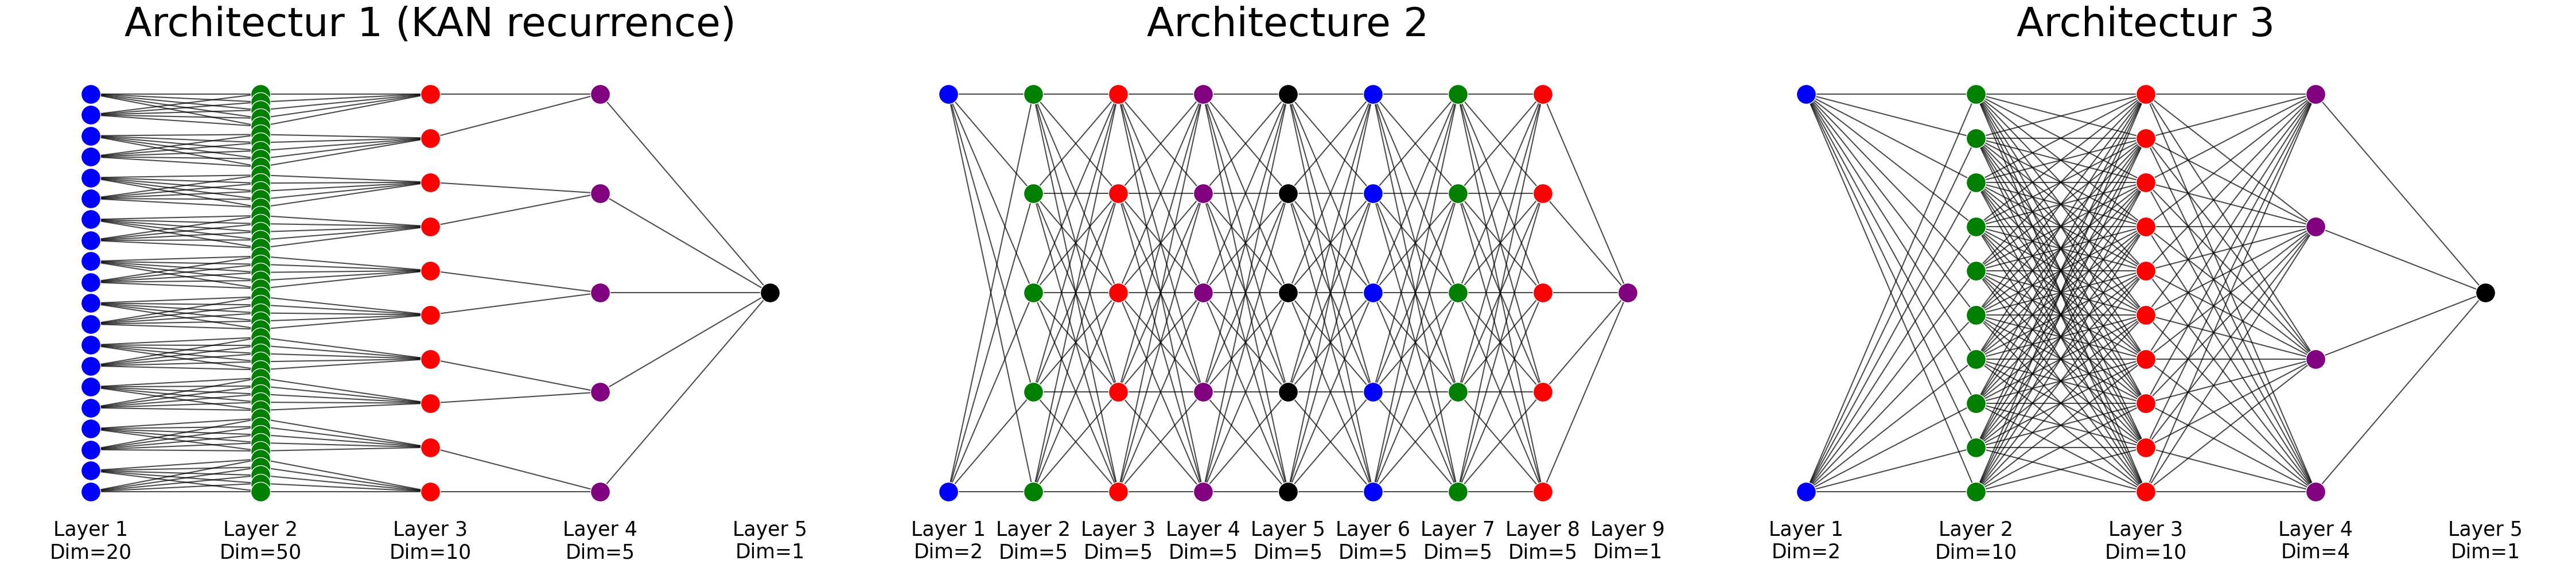

In [101]:
# Assuming 'results' is a list of dictionaries containing 'masking_matrices'
# Example structure:
# results = [
#     {'masking_matrices': mask1},
#     {'masking_matrices': mask2},
#     {'masking_matrices': mask3},
#     # ... more results
# ]

# Number of plots you want side by side
num_plots = 3

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, num_plots, figsize=(15 * num_plots, 10))

# If there's only one plot, axes might not be iterable
if num_plots == 1:
    axes = [axes]

for inx in range(num_plots):
    # Extract and convert masking matrices to NumPy arrays


    if inx == 0:
        masking_matrices = [np.array(matrix) for matrix in results[inx]['masking_matrices']]
        title = f"Architectur 1 (KAN recurrence)"
    if inx ==1:
        masking_matrices = [
            [[1, 1],
            [1, 1],
            [1, 1],
            [1, 1],
            [1, 1]],
            
            [[1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1]],

            [[1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1]],
            
            [[1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1]],
            
            [[1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1]],
            
            [[1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1]],
            
            [[1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1]],
            
            [[1, 1, 1, 1, 1]]]
        title = f"Architecture 2"
    if inx == 2:
        masking_matrices = [
            [[1, 1],
            [1, 1],
            [1, 1],
            [1, 1],
            [1, 1],
            [1, 1],
            [1, 1],
            [1, 1],
            [1, 1],
            [1, 1]],
            
            [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
            
            [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],

            [[1,1,1,1]]]        
        title = f"Architectur 3"
        
    # Plot on the respective axis
    plot_network(masking_matrices, figsize=(15, 10),
                title=f"Network Visualization {inx + 1}",
                ax=axes[inx])

    axes[inx].set_title(title, fontsize=50)

plt.tight_layout()
plt.show()



mask2 = [
    [[1, 1],
     [1, 1],
     [1, 1],
     [1, 1],
     [1, 1]],
    
    [[1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1]],

     [[1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1]],
     
    [[1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1]],
    
    [[1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1]],
    
    [[1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1]],
    
    [[1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1]],
    
    [[1, 1, 1, 1, 1]]
]



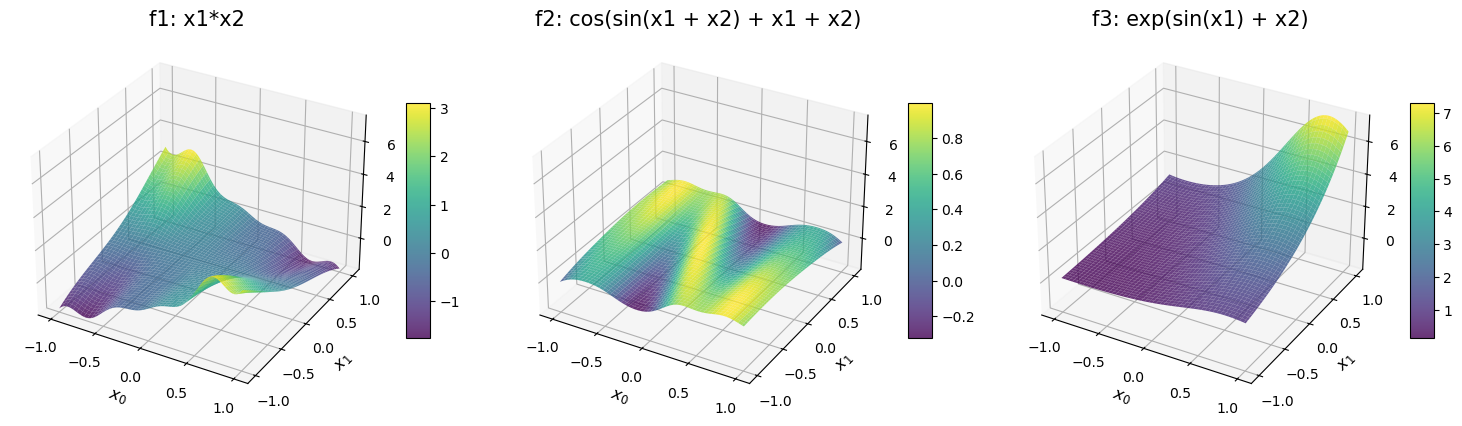

In [112]:

# Define named target functions with correct indexing
def f1(x):
    """
    Computes the product of the first and second elements.
    x: Tensor of shape (resolution, resolution, 2)
    Returns: Tensor of shape (resolution, resolution)
    """
    return -5*torch.cos(torch.sin(x[:, :, 0]*5))*x[:, :, 0] * x[:, :, 1]*torch.cos(torch.sin(x[:, :, 0] + x[:, :, 1]))

def f2(x):
    """
    Computes the cosine of (sine(x0 + x1) + x0 + x1).
    x: Tensor of shape (resolution, resolution, 2)
    Returns: Tensor of shape (resolution, resolution)
    """
    return torch.cos(torch.sin(5*x[:, :, 0] + x[:, :, 1]) + x[:, :, 0] + x[:, :, 1])*torch.cos(torch.sin(x[:, :, 0] + x[:, :, 1]))


def f3(x):
    """
    Computes the exponential of (sine(x0) + x1).
    x: Tensor of shape (resolution, resolution, 2)
    Returns: Tensor of shape (resolution, resolution)
    """
    return torch.exp(torch.sin(2*x[:, :, 0]) + x[:, :, 1])


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

def plot_functions_side_by_side(functions, 
                                x_range=[-1, 1], 
                                resolution=100, 
                                figsize=(15, 5), 
                                titles=None, 
                                save_path=None):
    """
    Plot multiple 3D surface plots side by side where each function accepts a single 2D tensor.
    
    Parameters
    ----------
    functions : list of callables
        A list where each element is a function that takes a single 2D NumPy array with shape 
        (resolution, resolution, 2) and returns a scalar NumPy array with shape (resolution, resolution).
    x_range : list or tuple, optional
        The range for both x0 and x1 axes as [min, max]. Default is [-1, 1].
    resolution : int, optional
        Number of points along each axis. Higher values yield smoother surfaces but take longer to compute. Default is 100.
    figsize : tuple, optional
        Size of the entire figure as (width, height). Adjust based on the number of plots. Default is (15, 5) for 3 plots.
    titles : list of str, optional
        A list of titles for each subplot. If None, default titles are used.
    save_path : str, optional
        If provided, saves the figure to the specified path.
    
    Raises
    ------
    ValueError
        If the number of titles doesn't match the number of functions.
    
    Example
    -------
    ```python
    import numpy as np
    import torch

    # Define sample functions
    def f1(x):
        return x[:, :, 0] * x[:, :, 1]

    def f2(x):
        return torch.cos(torch.sin(x[:, :, 0] + x[:, :, 1]) + x[:, :, 0] + x[:, :, 1])

    def f3(x):
        return torch.exp(torch.sin(x[:, :, 0]) + x[:, :, 1])

    target_function_list = [f1, f2, f3]
    titles = ["f1: x0 * x1", "f2: cos(sin(x0 + x1) + x0 + x1)", "f3: exp(sin(x0) + x1)"]

    plot_functions_side_by_side(target_function_list, titles=titles)
    ```
    """
    num_funcs = len(functions)
    
    if titles is not None and len(titles) != num_funcs:
        raise ValueError("The number of titles must match the number of functions.")
    
    # Create meshgrid
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(x_range[0], x_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    
    # Stack X and Y to create a single 2D tensor for each function
    # Shape: (resolution, resolution, 2)
    XY = np.stack((X, Y), axis=-1)
    
    # Convert XY to a PyTorch tensor
    XY_torch = torch.tensor(XY, dtype=torch.float32)
    
    # Evaluate all functions to obtain Z values
    Z_values = []
    for idx, func in enumerate(functions):
        try:
            Z_torch = func(XY_torch)
            if not isinstance(Z_torch, torch.Tensor):
                raise TypeError(f"Function {idx+1} did not return a PyTorch tensor.")
            if Z_torch.shape != (resolution, resolution):
                raise ValueError(f"Function {idx+1} returned tensor with shape {Z_torch.shape}, expected {(resolution, resolution)}.")
            # Detach and convert to NumPy
            Z = Z_torch.detach().cpu().numpy()
            Z_values.append(Z)
        except Exception as e:
            raise ValueError(f"Error evaluating function {idx+1}: {e}")
    
    # Determine global z limits for consistency across plots
    Z_all = np.array(Z_values)
    z_min = np.min(Z_all)
    z_max = np.max(Z_all)
    
    # Create subplots
    fig = plt.figure(figsize=figsize)
    
    for idx, Z in enumerate(Z_values):
        ax = fig.add_subplot(1, num_funcs, idx + 1, projection='3d')
        
        # Plot the surface
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
        
        # Customize the z axis for better comparison
        ax.set_zlim(z_min, z_max)
        
        # Set labels
        ax.set_xlabel('$x_0$', fontsize=12)
        ax.set_ylabel('$x_1$', fontsize=12)
        ax.set_zlabel('$f(X)$', fontsize=12)
        
        # Set title
        if titles is not None:
            ax.set_title(titles[idx], fontsize=15)
        else:
            ax.set_title(f'Function {idx + 1}', fontsize=15)
        
        # Add a color bar for each subplot
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    
    plt.tight_layout()
    
    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
    
    plt.show()


# List of target functions
target_function_list = [f1, f2, f3]

# Titles for each subplot
titles = ["f1: x1*x2", "f2: cos(sin(x1 + x2) + x1 + x2)", "f3: exp(sin(x1) + x2)"]

plot_functions_side_by_side(target_function_list, titles=titles)

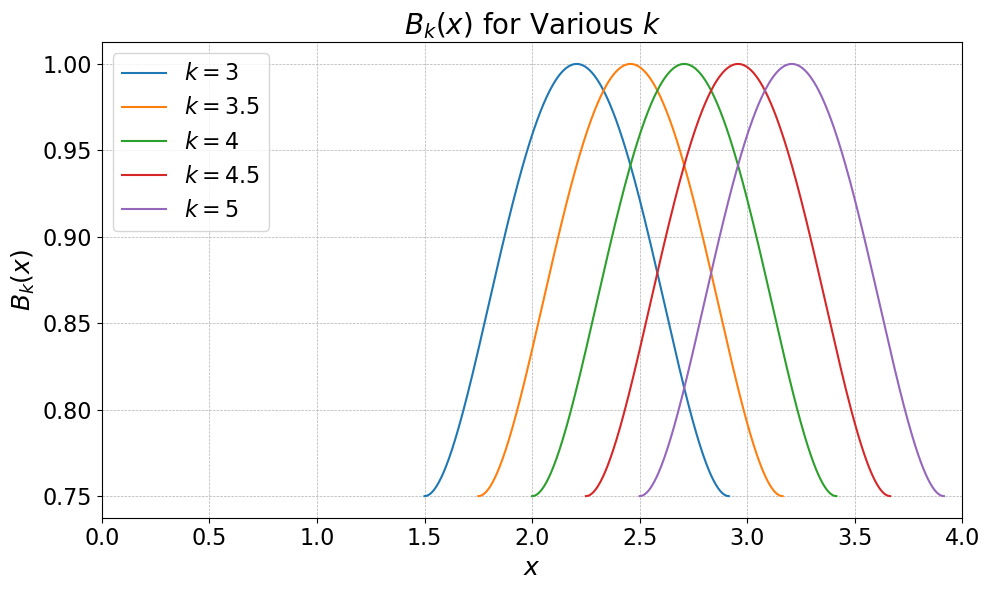

In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Adjustable font sizes
title_fontsize = 20
label_fontsize = 18
legend_fontsize = 16
tick_fontsize = 16  # New variable for tick labels

# Define the k values
# k_values = [0, 0.5, 1, 1.5, 2]
k_values = [3,3.5,4,4.5,5]
# Initialize the plot
plt.figure(figsize=(10, 6))
g = 4  # Not used in the current plot, consider removing if unnecessary

# Iterate over each k and plot B_k(x)
for k in k_values:
    # Define the x range for the current k
    x_min = k / 2
    x_max = np.sqrt(2) + k / 2
    x = np.linspace(x_min, x_max, 400)
    
    # Compute B_k(x)
    y = ((x - np.sqrt(0.5) - k / 2)**4 - (x - np.sqrt(0.5) - k / 2)**2) + 1
    
    # Plot the function with a label
    plt.plot(x, y, label=f'$k={k}$')

# Set the title and labels with adjustable font sizes
plt.title(r'$B_k(x)$ for Various $k$', fontsize=title_fontsize)
plt.xlabel('$x$', fontsize=label_fontsize)
plt.ylabel('$B_k(x)$', fontsize=label_fontsize)

# Customize tick label font sizes
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# Add a legend with adjustable font size
plt.legend(fontsize=legend_fontsize)

# Fix the x-axis to always show a fixed range including (0,0)
plt.xlim(0, 4)  # Adjust the upper limit as needed

# Optional: Add grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()

